🚀 Regenerating complete GLV1 data including r parameters...


100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 266.58it/s]


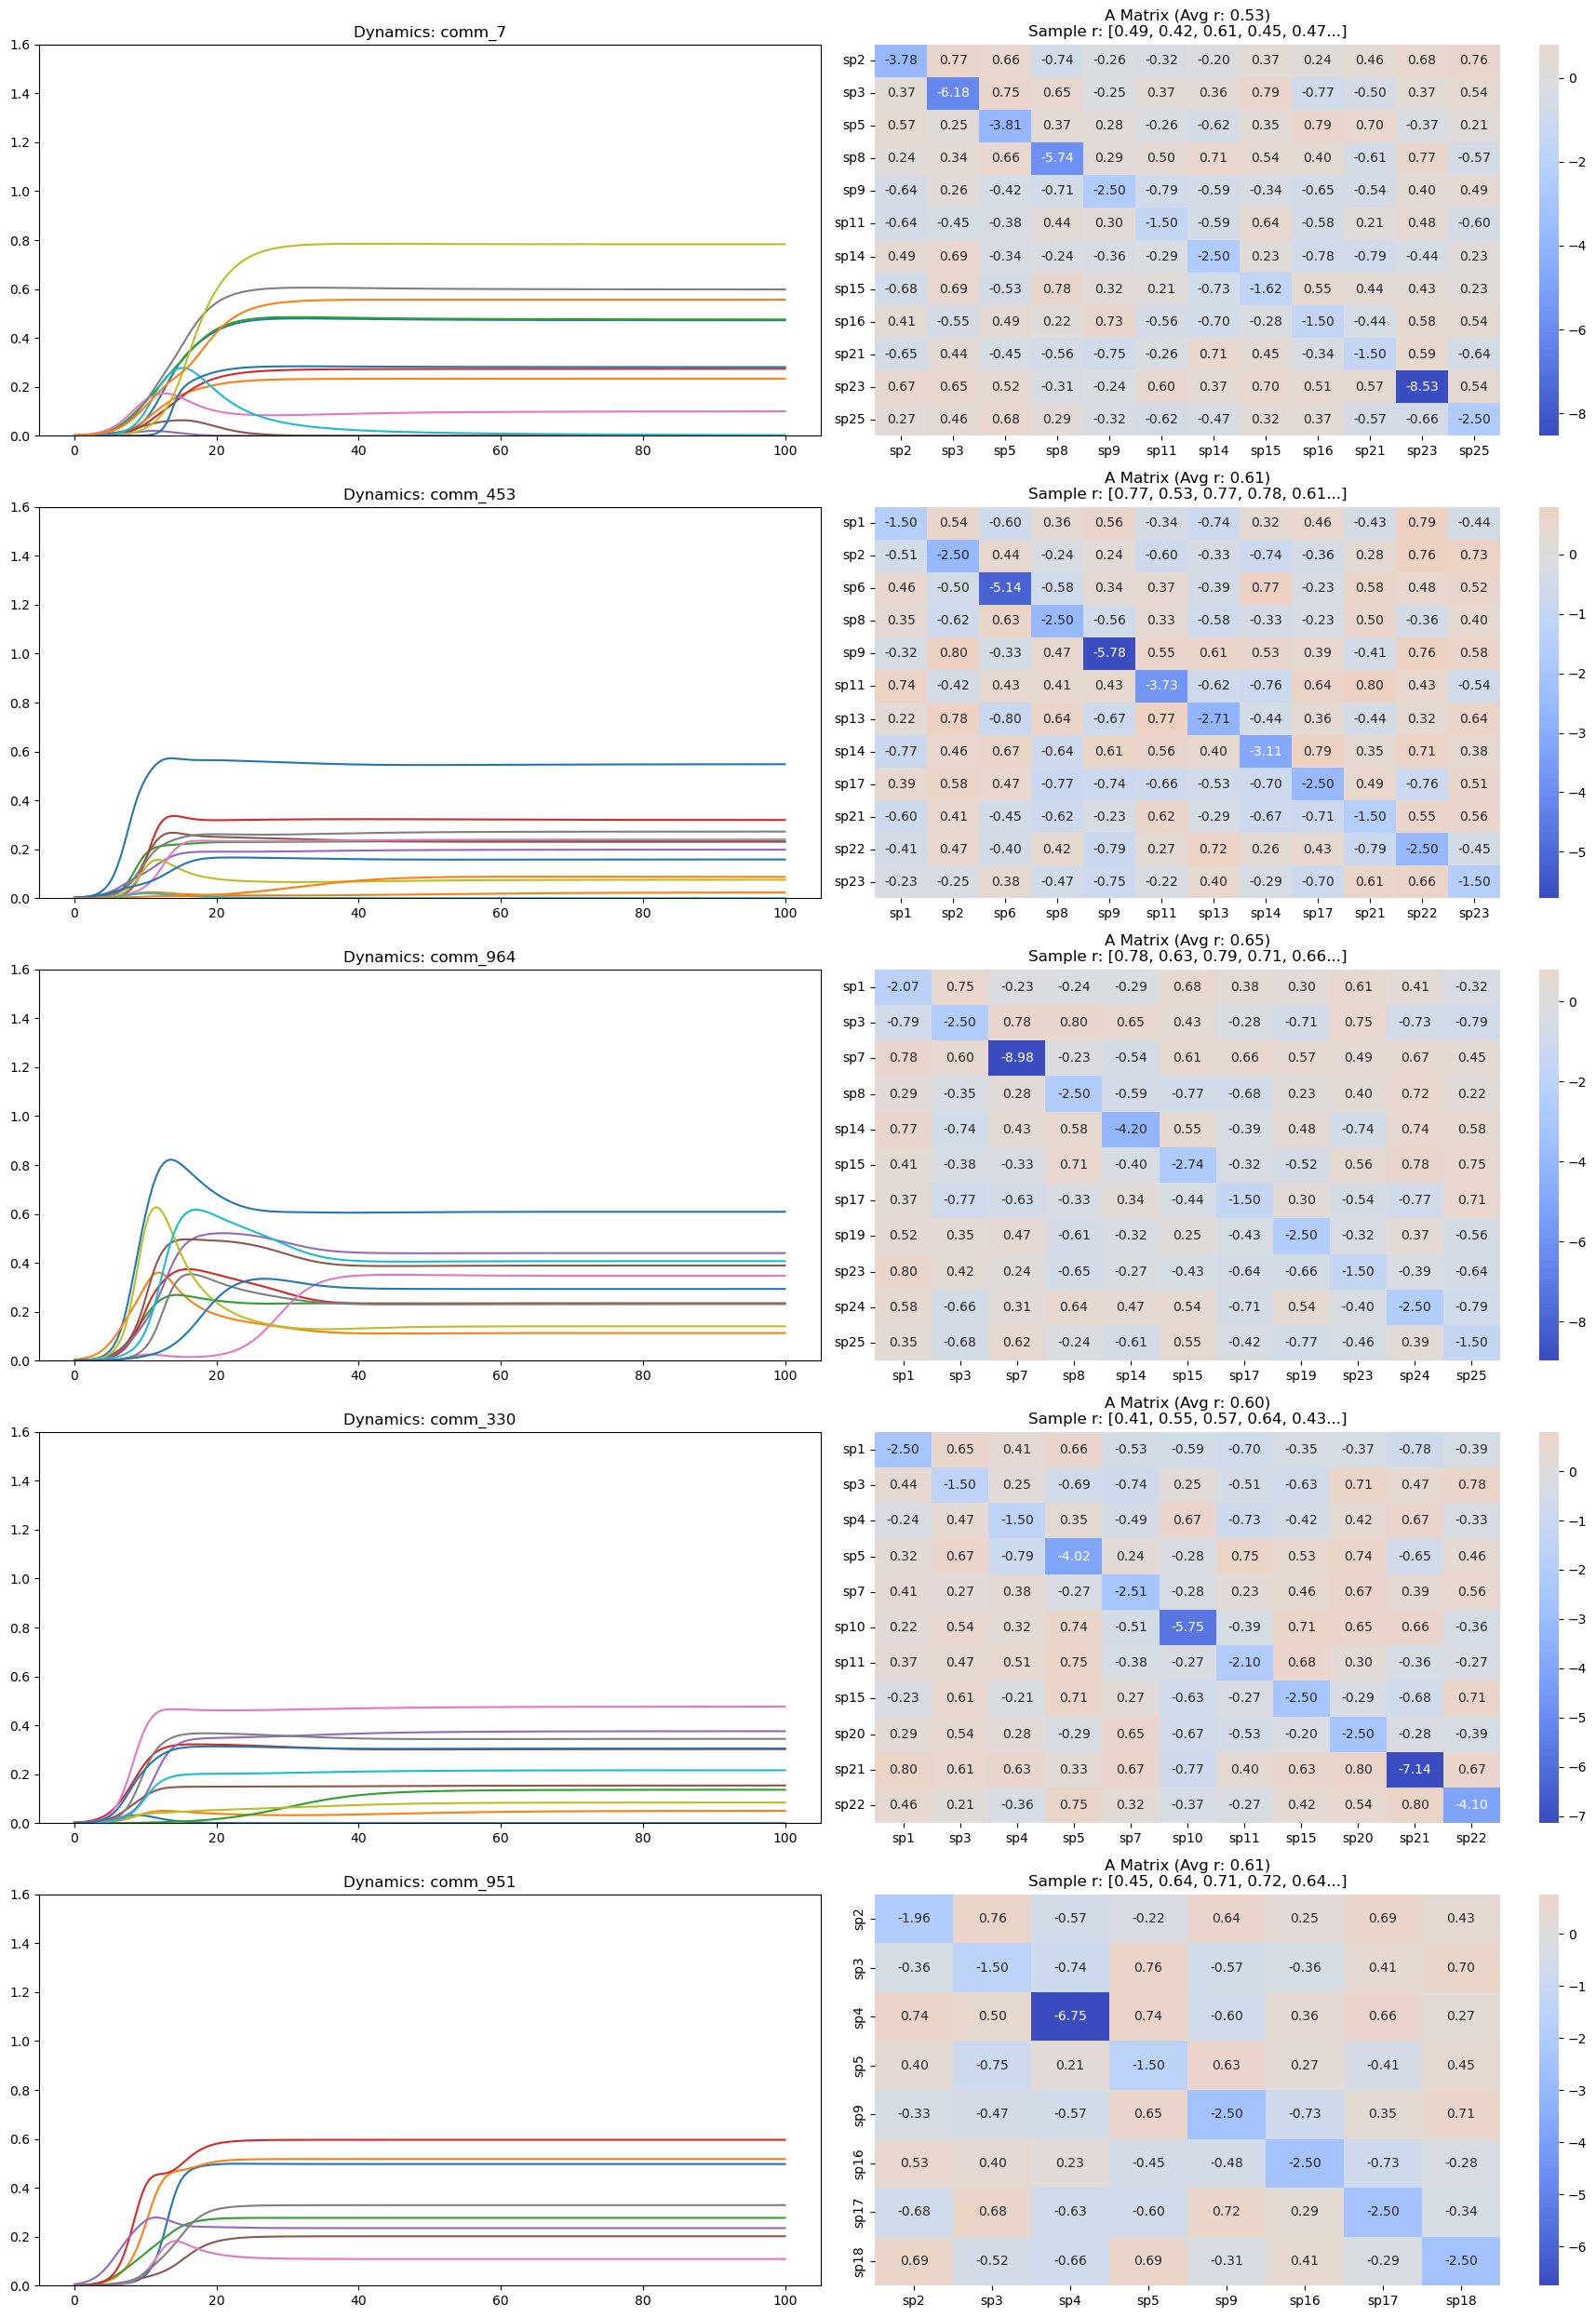

✅ Done! Parameters now include r and have been saved to glv_positive_strong_complete


In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from joblib import Parallel, delayed
from tqdm import tqdm

# ==========================================
# 1. Configuration
# ==========================================
N_COMMUNITIES = 1000
N_SPECIES = 25
COMM_SIZE_RANGE = (8, 12)
T_EVAL = np.linspace(0, 100, 201)
TOTAL_X0 = 0.01
OUT_DIR = "glv_positive_strong_complete"
os.makedirs(OUT_DIR, exist_ok=True)

def generate_complete_glv1_params(n_present, seed):
    rng = np.random.default_rng(seed)
    
    # Assign ecological roles
    n_high = max(1, int(n_present * 0.4))
    high_idx = rng.choice(n_present, size=n_high, replace=False)
    
    # 1. Generate r and explicitly store it
    r = rng.uniform(0.4, 0.8, size=n_present)
    
    # 2. Generate strong interaction matrix A (positive mean)
    A = rng.uniform(0.2, 0.8, size=(n_present, n_present))
    signs = rng.choice([-1, 1], size=(n_present, n_present), p=[0.4, 0.6])
    A = A * signs
    
    # 3. Diagonal stability control
    for i in range(n_present):
        net_effect = np.sum(A[i, :]) - A[i, i]
        if i in high_idx:
            target = rng.uniform(1.2, 1.45)
            A[i, i] = -max(1.5, (r[i] + net_effect) / target)
        else:
            target = rng.uniform(0.5, 0.8)
            A[i, i] = -max(2.5, (r[i] + net_effect) / target)
            
    return r, A

def simulate_complete_glv1(c_idx):
    seed = 666 + c_idx
    rng = np.random.default_rng(seed)
    k = rng.integers(COMM_SIZE_RANGE[0], COMM_SIZE_RANGE[1] + 1)
    present_species = rng.choice(N_SPECIES, size=k, replace=False)
    present_species.sort()
    
    # Retrieve parameters including r
    r_sub, A_sub = generate_complete_glv1_params(k, seed)
    x0_sub = rng.dirichlet(np.ones(k)) * TOTAL_X0
    
    sol = solve_ivp(
        lambda t, x: x * (r_sub + A_sub @ x),
        (T_EVAL[0], T_EVAL[-1]),
        x0_sub,
        t_eval=T_EVAL,
        method='BDF'
    )
    
    if not sol.success:
        return None

    res_list = []
    for i, t in enumerate(T_EVAL):
        row = {"Comm_name": f"comm_{c_idx}", "Time": t}
        abundances = np.zeros(N_SPECIES)
        abundances[present_species] = np.clip(sol.y[:, i], 0, 1.5)
        for s_idx in range(N_SPECIES):
            row[f"sp{s_idx+1}"] = abundances[s_idx]
        res_list.append(row)
        
    # Return full dictionary including r
    param_info = {
        "id": c_idx,
        "present_species": present_species,
        "r": r_sub,
        "A": A_sub
    }
    return res_list, param_info

# ==========================================
# 2. Run Simulation
# ==========================================
if __name__ == "__main__":
    print("🚀 Regenerating complete GLV1 data including r parameters...")
    results = Parallel(n_jobs=-1)(
        delayed(simulate_complete_glv1)(i) for i in tqdm(range(N_COMMUNITIES))
    )
    
    results = [r for r in results if r is not None]
    
    # Save CSV
    all_rows = [row for res_list, p in results for row in res_list]
    pd.DataFrame(all_rows).to_csv(
        os.path.join(OUT_DIR, "glv1_complete.csv"),
        index=False
    )
    
    # Save parameter file including r
    complete_params = {f"comm_{p['id']}": p for _, p in results}
    np.save(
        os.path.join(OUT_DIR, "pos_strong_params_complete.npy"),
        complete_params
    )
    
    # ==========================================
    # 3. Plotting (Heatmap shows r on the side for inspection)
    # ==========================================
    sample_ids = np.random.choice(list(complete_params.keys()), 5, replace=False)
    fig, axes = plt.subplots(5, 2, figsize=(18, 25))

    for i, cid in enumerate(sample_ids):
        info = complete_params[cid]
        
        # Plot Time Series
        ax_ts = axes[i, 0]
        data = pd.read_csv(os.path.join(OUT_DIR, "glv1_complete.csv"))
        comm_data = data[data['Comm_name'] == cid]
        for col in [c for c in data.columns if c.startswith("sp")]:
            if comm_data[col].max() > 0.0001:
                ax_ts.plot(comm_data['Time'], comm_data[col], label=col)
        ax_ts.set_title(f"Dynamics: {cid}")
        ax_ts.set_ylim(0, 1.6)

        # Plot Heatmap (with r annotation)
        ax_hm = axes[i, 1]
        labels = [f"sp{s+1}" for s in info['present_species']]
        
        sns.heatmap(
            info['A'],
            ax=ax_hm,
            annot=True,
            fmt=".2f",
            cmap="coolwarm",
            center=0,
            xticklabels=labels,
            yticklabels=labels
        )
        
        r_str = ", ".join([f"{val:.2f}" for val in info['r'][:5]])  # Show first 5 r values
        ax_hm.set_title(
            f"A Matrix (Avg r: {np.mean(info['r']):.2f})\nSample r: [{r_str}...]"
        )

    plt.tight_layout()
    plt.show()
    print(f"✅ Done! Parameters now include r and have been saved to {OUT_DIR}")

[load] glv_positive_strong_complete/pos_strong_params_complete.npy
[load] N_COMM=1000, inferred N_SPECIES=25
[done] built FULL GLV1 arrays: r1 synthesized; A1 embedded
wrote: glv_positive_strong_complete/params_glv1_standard.npz
[done] GLV2 generated: r2 strictly slower; A2 can strengthen or weaken
wrote: glv_positive_strong_complete/params_glv2.npz
wrote: glv_positive_strong_complete/meta_glv2.json
[plot] comm_814  n_present=9


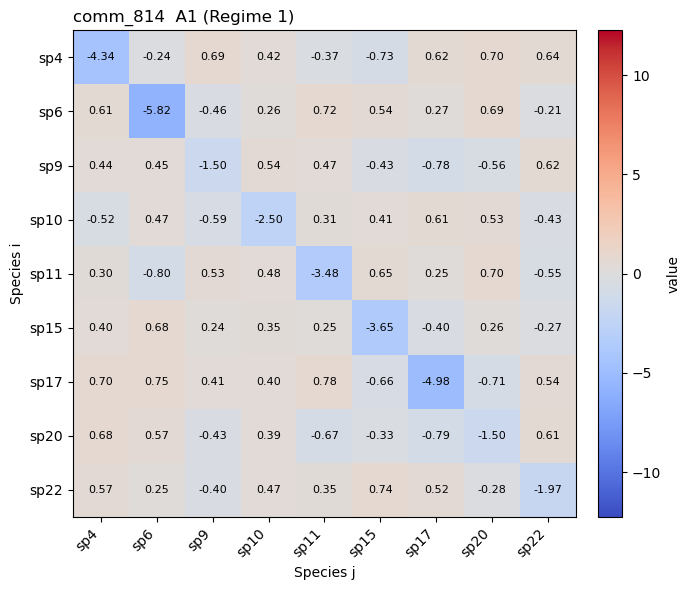

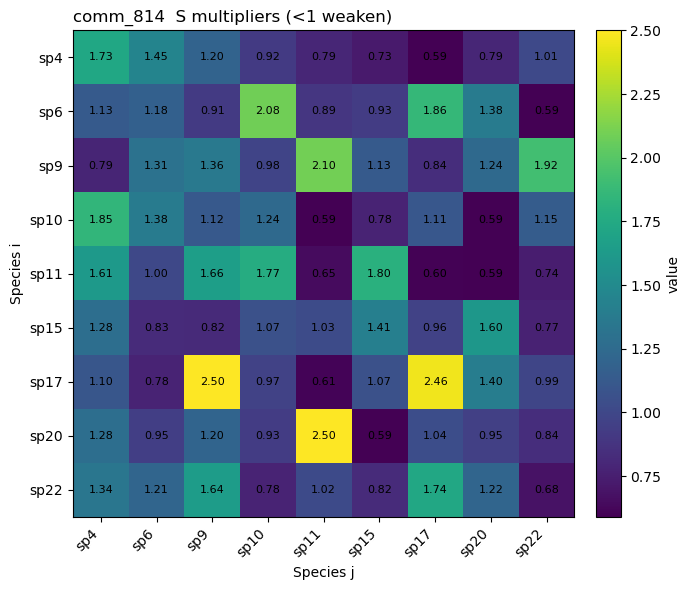

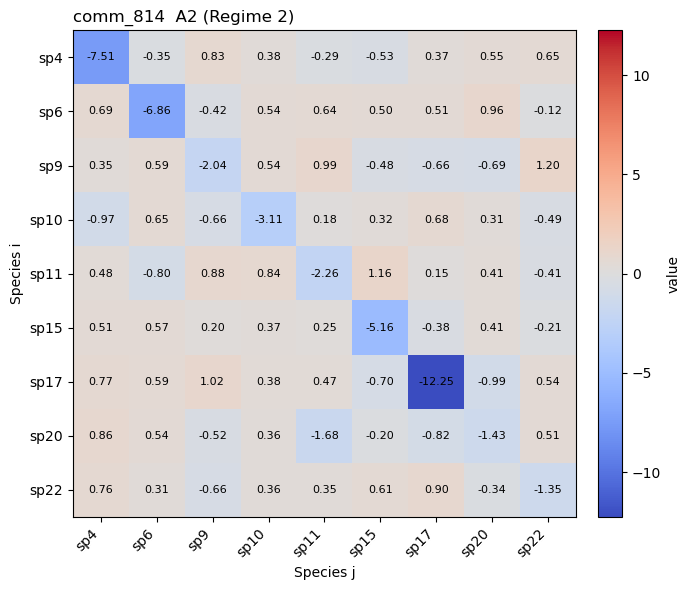

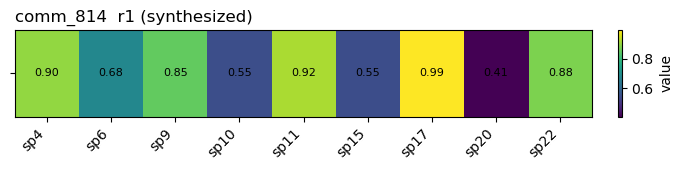

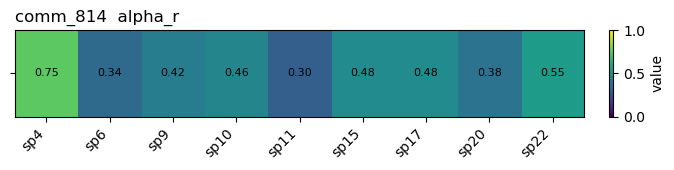

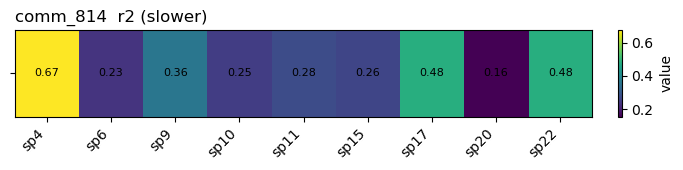

In [3]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

# =========================================================
# 0) Config
# =========================================================
OUT_DIR = "glv_positive_strong_complete"
IN_NPY = os.path.join(OUT_DIR, "pos_strong_params_complete.npy")

SEED = 7
rng = np.random.default_rng(SEED)

# ---- GLV1: your file has no r, so we synthesize r1 for present species ----
R1_RANGE = (0.4, 1.0)   # positive r1 for present species only

# ---- GLV2: slower growth, different degree per species ----
ALPHA_R_LOW, ALPHA_R_HIGH = 0.25, 0.75

# ---- GLV2: A weakened heterogeneously, strictly <1 ----
MU_SCALE = 0.60
SIGMA_SCALE = 0.45
CLIP_LOW, CLIP_HIGH = 0.15, 0.95   # <1 => always weaken
DIAG_MULTIPLIER = 1.00
OFFDIAG_MULTIPLIER = 1.00
PRESERVE_ZERO_ENTRIES = False      # you prefer no zero-interaction; keep False

# Outputs
OUT_GLV1_STD_NPZ = os.path.join(OUT_DIR, "params_glv1_standard.npz")
OUT_GLV2_NPZ     = os.path.join(OUT_DIR, "params_glv2.npz")
OUT_META_JSON    = os.path.join(OUT_DIR, "meta_glv2.json")

# Plot
PLOT_ONE_COMMUNITY = True
PLOT_COMM_KEY = None   # e.g. "comm_0"; None -> random
ANNOTATE = True
FMT = ".2f"
FONT_SIZE = 8

# =========================================================
# 1) Load dict keyed by comm_0, comm_1, ...
# =========================================================
obj = np.load(IN_NPY, allow_pickle=True)
if not (isinstance(obj, np.ndarray) and obj.shape == () and isinstance(obj.item(), dict)):
    raise ValueError("Expected pos_strong_params.npy to be a dict-like npy (np.load(...).item() dict).")

top = obj.item()
comm_keys = [k for k in top.keys() if str(k).startswith("comm_")]
if not comm_keys:
    raise ValueError(f"No keys like 'comm_0' found. First keys: {list(top.keys())[:20]}")

def _comm_index(k):
    try:
        return int(str(k).split("_")[-1])
    except:
        return 10**9

comm_keys = sorted(comm_keys, key=_comm_index)
comm_names = np.array([str(k) for k in comm_keys], dtype=object)
N_COMM = len(comm_keys)

# infer global species pool size from present_species across all comms
max_sp = -1
for ck in comm_keys:
    ps = np.asarray(top[ck]["present_species"], dtype=int)
    if ps.size:
        max_sp = max(max_sp, int(ps.max()))
N_SPECIES = max_sp + 1
print(f"[load] {IN_NPY}")
print(f"[load] N_COMM={N_COMM}, inferred N_SPECIES={N_SPECIES}")

# =========================================================
# 2) Build FULL GLV1 arrays (uniform shapes)
# =========================================================
mask_all = np.zeros((N_COMM, N_SPECIES), dtype=bool)
r1_all   = np.zeros((N_COMM, N_SPECIES), dtype=np.float32)
A1_all   = np.zeros((N_COMM, N_SPECIES, N_SPECIES), dtype=np.float32)

for i, ck in enumerate(comm_keys):
    d = top[ck]
    present = np.asarray(d["present_species"], dtype=int)
    A_sub = np.asarray(d["A"], dtype=float)

    k = present.size
    if A_sub.ndim != 2 or A_sub.shape[0] != A_sub.shape[1]:
        raise ValueError(f"{ck}: A must be square 2D. Got {A_sub.shape}")
    if k != A_sub.shape[0]:
        raise ValueError(f"{ck}: present_species size {k} must match A shape {A_sub.shape}")

    # mask
    mask_all[i, present] = True

    # synthesize r1 for present species
    r1_all[i, present] = rng.uniform(R1_RANGE[0], R1_RANGE[1], size=k).astype(np.float32)

    # embed A_sub into full A
    A1_all[i][np.ix_(present, present)] = A_sub.astype(np.float32)

print("[done] built FULL GLV1 arrays: r1 synthesized; A1 embedded")

np.savez_compressed(
    OUT_GLV1_STD_NPZ,
    comm_names=comm_names,
    mask=mask_all,
    r=r1_all,
    A=A1_all,
)
print("wrote:", OUT_GLV1_STD_NPZ)

# =========================================================
# 3) Generate FULL GLV2 arrays (r slower; A can strengthen or weaken)
# =========================================================
# ---- r2: strictly slower for present species ----
ALPHA_R_LOW, ALPHA_R_HIGH = 0.25, 0.75   # <1 => always slower

# ---- A2: allow strengthen OR weaken ----
# S is lognormal centered around 1.0 (median ~ 1), so S can be >1 or <1
S_SIGMA = 0.35          # heterogeneity (bigger => more varied strengthen/weaken)
S_MEDIAN_TARGET = 1.0   # keep median around 1 so it's not systematically weaker/stronger
S_CLIP_LOW, S_CLIP_HIGH = 0.59, 2.50     # allow both <1 and >1, but avoid extremes
DIAG_MULTIPLIER = 1.10                  # optional: slightly change self-interaction more
OFFDIAG_MULTIPLIER = 1.00
PRESERVE_ZERO_ENTRIES = False           # if A1 has zeros but you don't want to force zeros, keep False

r2_all = np.zeros_like(r1_all, dtype=np.float32)
A2_all = np.zeros_like(A1_all, dtype=np.float32)
alpha_r_all = np.zeros_like(r1_all, dtype=np.float32)
S_all = np.zeros_like(A1_all, dtype=np.float32)

for c in range(N_COMM):
    r1 = r1_all[c].astype(float)
    A1 = A1_all[c].astype(float)
    mask = mask_all[c]
    present = np.where(mask)[0]

    # alpha per species (present only) => r2 strictly slower
    alpha = np.zeros(N_SPECIES, dtype=float)
    if present.size > 0:
        alpha[present] = rng.uniform(ALPHA_R_LOW, ALPHA_R_HIGH, size=present.size)
    r2 = alpha * r1

    # S multipliers: lognormal >0, median ~ 1, can be >1 or <1
    S = rng.lognormal(mean=0.0, sigma=S_SIGMA, size=(N_SPECIES, N_SPECIES))

    # rescale median to target (median(lognormal)=exp(mean)=1 if mean=0; still rescale for stability)
    S = S * (S_MEDIAN_TARGET / np.median(S))

    # clip to allow both strengthening and weakening but prevent explosion
    S = np.clip(S, S_CLIP_LOW, S_CLIP_HIGH)

    # diag/offdiag multipliers
    for i in range(N_SPECIES):
        S[i, i] *= DIAG_MULTIPLIER
    if OFFDIAG_MULTIPLIER != 1.0:
        off_mask = ~np.eye(N_SPECIES, dtype=bool)
        S[off_mask] *= OFFDIAG_MULTIPLIER

    S = np.clip(S, S_CLIP_LOW, S_CLIP_HIGH)

    # preserve sparsity only if you want
    if PRESERVE_ZERO_ENTRIES:
        S = np.where(A1 == 0.0, 0.0, S)

    A2 = A1 * S

    r2_all[c] = r2.astype(np.float32)
    A2_all[c] = A2.astype(np.float32)
    alpha_r_all[c] = alpha.astype(np.float32)
    S_all[c] = S.astype(np.float32)

print("[done] GLV2 generated: r2 strictly slower; A2 can strengthen or weaken")

# =========================================================
# 3b) STORE GLV2 parameters to file
# =========================================================
import pandas as pd

# --- 1) save everything to one compressed npz (recommended) ---
np.savez_compressed(
    OUT_GLV2_NPZ,
    comm_names=comm_names,
    mask=mask_all.astype(bool),
    r2=r2_all,
    A2=A2_all,
    alpha_r=alpha_r_all,  # per-species slowing factors
    S=S_all,              # per-entry interaction multipliers
)
print("wrote:", OUT_GLV2_NPZ)

# --- 2) write a small json metadata file (recommended) ---
meta = dict(
    SEED=SEED,
    input_npy=IN_NPY,
    N_COMM=int(N_COMM),
    N_SPECIES=int(N_SPECIES),

    # r2 design
    r2_rule=f"r2_i = alpha_i * r1_i; alpha_i ~ Uniform({ALPHA_R_LOW},{ALPHA_R_HIGH}) for present species",

    # A2 design
    A2_rule=(
        f"A2 = A1 ⊙ S; S lognormal(sigma={S_SIGMA}) rescaled to median {S_MEDIAN_TARGET}, "
        f"clipped to [{S_CLIP_LOW},{S_CLIP_HIGH}] (can strengthen or weaken)"
    ),
    DIAG_MULTIPLIER=DIAG_MULTIPLIER,
    OFFDIAG_MULTIPLIER=OFFDIAG_MULTIPLIER,
    PRESERVE_ZERO_ENTRIES=PRESERVE_ZERO_ENTRIES,
)
with open(OUT_META_JSON, "w") as f:
    json.dump(meta, f, indent=2)
print("wrote:", OUT_META_JSON)


# =========================================================
# 4) Plot one community (present-only submatrix) with numbers
# =========================================================
def heatmap(M, labels, title, vmin=None, vmax=None, cmap="coolwarm",
            annotate=True, fmt=".2f", fontsize=8, figsize=(7,6)):
    M = np.asarray(M, float)
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(M, vmin=vmin, vmax=vmax, cmap=cmap, aspect="auto")
    ax.set_title(title, loc="left")
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticklabels(labels)
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("value")
    if annotate:
        for i in range(M.shape[0]):
            for j in range(M.shape[1]):
                ax.text(j, i, format(M[i, j], fmt), ha="center", va="center", fontsize=fontsize)
    ax.set_xlabel("Species j")
    ax.set_ylabel("Species i")
    plt.tight_layout()
    plt.show()

def heatmap_vec(v, labels, title, vmin=None, vmax=None, cmap=None,
                annotate=True, fmt=".2f", fontsize=8, figsize=(7,1.8)):
    v = np.asarray(v, float).reshape(1, -1)
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(v, vmin=vmin, vmax=vmax, cmap=cmap, aspect="auto")
    ax.set_title(title, loc="left")
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticks([0]); ax.set_yticklabels([""])
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("value")
    if annotate:
        for j in range(v.shape[1]):
            ax.text(j, 0, format(v[0, j], fmt), ha="center", va="center", fontsize=fontsize)
    plt.tight_layout()
    plt.show()

if PLOT_ONE_COMMUNITY:
    if PLOT_COMM_KEY is None:
        idx = int(rng.integers(0, N_COMM))
        ck = str(comm_names[idx])
    else:
        ck = str(PLOT_COMM_KEY)
        idx = int(np.where(comm_names == ck)[0][0])

    present = np.where(mask_all[idx])[0]
    labels = [f"sp{i}" for i in present]

    A1p = A1_all[idx][np.ix_(present, present)]
    A2p = A2_all[idx][np.ix_(present, present)]
    Sp  = S_all[idx][np.ix_(present, present)]
    r1p = r1_all[idx, present]
    r2p = r2_all[idx, present]
    ap  = alpha_r_all[idx, present]

    abs_max = max(np.abs(A1p).max(), np.abs(A2p).max())
    vmin, vmax = -abs_max, abs_max

    print(f"[plot] {ck}  n_present={present.size}")
    heatmap(A1p, labels, f"{ck}  A1 (Regime 1)", vmin=vmin, vmax=vmax, annotate=ANNOTATE, fmt=FMT, fontsize=FONT_SIZE)
    heatmap(Sp,  labels, f"{ck}  S multipliers (<1 weaken)", cmap=None, annotate=ANNOTATE, fmt=FMT, fontsize=FONT_SIZE)
    heatmap(A2p, labels, f"{ck}  A2 (Regime 2)", vmin=vmin, vmax=vmax, annotate=ANNOTATE, fmt=FMT, fontsize=FONT_SIZE)

    heatmap_vec(r1p, labels, f"{ck}  r1 (synthesized)", annotate=ANNOTATE, fmt=FMT, fontsize=FONT_SIZE)
    heatmap_vec(ap,  labels, f"{ck}  alpha_r", vmin=0.0, vmax=1.0, annotate=ANNOTATE, fmt=FMT, fontsize=FONT_SIZE)
    heatmap_vec(r2p, labels, f"{ck}  r2 (slower)", annotate=ANNOTATE, fmt=FMT, fontsize=FONT_SIZE)

In [4]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# ============================================================
# 0) Config
# ============================================================
OUT_DIR = "glv_positive_strong_interactions"

GLV1_NPZ = os.path.join(OUT_DIR, "params_glv1_standard.npz")  # has r/A/mask/comm_names/(maybe x0)
GLV2_NPZ = os.path.join(OUT_DIR, "params_glv2.npz")           # has r2/A2/mask/comm_names

OUT_SIM_ABUND    = os.path.join(OUT_DIR, "simulated_abundance_switch.csv")
OUT_DEP_PROD_TS  = os.path.join(OUT_DIR, "depletion_production_timeseries.csv")
OUT_PROD_SUMMARY = os.path.join(OUT_DIR, "production_output_summary.csv")
OUT_META_JSON    = os.path.join(OUT_DIR, "switch_meta.json")
OUT_TS_HIST_PNG  = os.path.join(OUT_DIR, "t_switch_hist.png")

SEED = 7
rng = np.random.default_rng(SEED)

# ============================================================
# 1) Time grid
# ============================================================
t0, tf = 0.0, 20.0
TIMEPOINTS = np.linspace(t0, tf, 201)   # dense -> smooth crossing time
TARGET_MEAN = 10.0
TARGET_SD   = 1.2
TARGET_CLIP = (7.0, 13.0)

# ============================================================
# 2) Metabolite & product knobs
# ============================================================
W_SIGMA = 0.50
W_MEAN_TARGET = 1.0

PRODUCER_K_RANGE = (2, 5)
C2_RANGE = (0.2, 1.2)

# make M0 slightly noisy so t_switch has variation even if target times collide on same grid
M0_JITTER_SIGMA = 0.05

# ============================================================
# 3) Solver stability
# ============================================================
METHOD = "Radau"     # stiff solver
atol, rtol = 1e-8, 1e-6
X_CLAMP = 50.0

# ============================================================
# 4) Helpers
# ============================================================
def cumulative_trapz(y: np.ndarray, x: np.ndarray) -> np.ndarray:
    y = np.asarray(y, float)
    x = np.asarray(x, float)
    out = np.zeros_like(x, dtype=float)
    dx = np.diff(x)
    out[1:] = np.cumsum(0.5 * (y[:-1] + y[1:]) * dx)
    return out

def estimate_crossing_time(t: np.ndarray, y: np.ndarray, level: float = 0.0) -> float | None:
    t = np.asarray(t, float)
    y = np.asarray(y, float)
    idx = np.where(y <= level)[0]
    if idx.size == 0:
        return None
    k = int(idx[0])
    if k == 0:
        return float(t[0])
    tL, tR = float(t[k-1]), float(t[k])
    yL, yR = float(y[k-1]), float(y[k])
    if yR == yL:
        return float(tR)
    frac = (level - yL) / (yR - yL)
    return float(tL + frac * (tR - tL))

def simulate_glv_on_grid(x0: np.ndarray, t_eval: np.ndarray, r: np.ndarray, A: np.ndarray) -> np.ndarray:
    x0 = np.maximum(np.asarray(x0, float), 0.0)
    t_eval = np.asarray(t_eval, float)
    n = x0.size
    if t_eval.size == 0:
        return np.zeros((0, n), float)
    if t_eval.size == 1:
        return x0.reshape(1, -1).copy()

    r = np.asarray(r, float)
    A = np.asarray(A, float)

    def rhs(t, x):
        x = np.maximum(np.asarray(x, float), 0.0)
        x = np.clip(x, 0.0, X_CLAMP)
        return x * (r + A @ x)

    sol = solve_ivp(
        rhs,
        (float(t_eval[0]), float(t_eval[-1])),
        x0,
        t_eval=t_eval,
        method=METHOD,
        atol=atol,
        rtol=rtol,
    )

    if (not sol.success) or (sol.y.shape[1] != t_eval.size):
        raise RuntimeError(f"ODE failed: {sol.message}")

    X = np.maximum(sol.y.T, 0.0)
    return np.clip(X, 0.0, X_CLAMP)

def sample_positive_w(mask: np.ndarray) -> np.ndarray:
    idx = np.where(mask)[0]
    w = np.zeros(mask.size, float)
    if idx.size == 0:
        return w
    w_sub = rng.lognormal(mean=0.0, sigma=W_SIGMA, size=idx.size)
    w_sub = w_sub * (W_MEAN_TARGET / np.mean(w_sub))
    w[idx] = w_sub
    return w

def sample_c2_producers(mask: np.ndarray, n_species: int) -> np.ndarray:
    idx = np.where(mask)[0]
    c2 = np.zeros(n_species, float)
    if idx.size == 0:
        return c2
    k_lo, k_hi = PRODUCER_K_RANGE
    k = int(rng.integers(k_lo, min(k_hi, idx.size) + 1))
    prod_idx = rng.choice(idx, size=k, replace=False)
    c2[prod_idx] = rng.uniform(C2_RANGE[0], C2_RANGE[1], size=k)
    return c2

def sample_target_time() -> float:
    t = float(rng.normal(TARGET_MEAN, TARGET_SD))
    return float(np.clip(t, TARGET_CLIP[0], TARGET_CLIP[1]))

# ============================================================
# 5) Load GLV1 + GLV2
# ============================================================
if not os.path.exists(GLV1_NPZ):
    raise FileNotFoundError(f"Missing {GLV1_NPZ}")
if not os.path.exists(GLV2_NPZ):
    raise FileNotFoundError(f"Missing {GLV2_NPZ}")

npz1 = np.load(GLV1_NPZ, allow_pickle=True)
npz2 = np.load(GLV2_NPZ, allow_pickle=True)

comm_names = np.array([str(x) for x in npz1["comm_names"]], dtype=object)

r1_all = np.asarray(npz1["r"] if "r" in npz1.files else npz1["r1"], float)
A1_all = np.asarray(npz1["A"] if "A" in npz1.files else npz1["A1"], float)
mask_all = np.asarray(npz1["mask"], bool)

# if x0 saved, use it; else fallback total=0.01 on present species
x0_all = np.asarray(npz1["x0"], float) if "x0" in npz1.files else None

r2_all = np.asarray(npz2["r2"], float)
A2_all = np.asarray(npz2["A2"], float)

N_COMM, N_SPECIES = r1_all.shape
sp_cols = [f"sp{i}" for i in range(1, N_SPECIES + 1)]
print(f"[load] N_COMM={N_COMM}, N_SPECIES={N_SPECIES}")

if x0_all is None:
    x0_all = np.zeros((N_COMM, N_SPECIES), float)
    for c in range(N_COMM):
        idx = np.where(mask_all[c])[0]
        if idx.size:
            frac = rng.dirichlet(np.full(idx.size, 2.0))
            x0_all[c, idx] = 0.01 * frac
    print("[init] x0 not found in npz; using Dirichlet total~0.01")
else:
    print("[init] loaded x0 from npz")

# ============================================================
# 6) Simulation (switch + no-switch), store results
# ============================================================
sim_rows = []
dep_rows = []
sum_rows = []
ts_rows  = []

fail_count = 0

for c in range(N_COMM):
    comm = str(comm_names[c])
    mask = mask_all[c]
    r1, A1 = r1_all[c], A1_all[c]
    r2, A2 = r2_all[c], A2_all[c]
    x0 = x0_all[c].copy()

    # per-community target time around 10
    t_target = sample_target_time()

    w = sample_positive_w(mask)                 # all present species consume
    c2 = sample_c2_producers(mask, N_SPECIES)   # subset produces

    # ---- GLV1-only trajectory (this will be the dashed "no-switch" line) ----
    try:
        X1_full = simulate_glv_on_grid(x0, TIMEPOINTS, r1, A1)
        failed_glv1 = False
    except Exception as e:
        X1_full = np.tile(x0.reshape(1, -1), (len(TIMEPOINTS), 1))
        failed_glv1 = True
        fail_count += 1

    # ---- choose M0 so depletion hits 0 near t_target (with mild jitter) ----
    rate1 = X1_full @ w
    consumed1 = cumulative_trapz(rate1, TIMEPOINTS)
    consumed_at_target = float(np.interp(t_target, TIMEPOINTS, consumed1))
    M0 = max(consumed_at_target, 1e-12) * float(rng.lognormal(mean=0.0, sigma=M0_JITTER_SIGMA))

    M1 = M0 - consumed1
    t_switch = estimate_crossing_time(TIMEPOINTS, M1, level=0.0)
    if t_switch is None:
        t_switch = float(t_target)  # fallback

    # ---- piecewise switch simulation (solid line) ----
    # IMPORTANT: to make pre-switch exactly match no-switch, we DO NOT re-integrate GLV1.
    X_switch = X1_full.copy()

    k = int(np.searchsorted(TIMEPOINTS, t_switch, side="right"))  # TIMEPOINTS[:k] <= t_switch
    x_sw = X1_full[k-1].copy() if k > 0 else x0.copy()

    failed_glv2 = False
    if k < len(TIMEPOINTS):
        try:
            X2 = simulate_glv_on_grid(x_sw, TIMEPOINTS[k:], r2, A2)
            X_switch[k:, :] = X2
        except Exception as e:
            # fallback: if glv2 fails, keep glv1-only for whole curve
            failed_glv2 = True
            fail_count += 1
            X_switch = X1_full.copy()

    # ---- compute M(t), P(t) from switched trajectory ----
    rate = X_switch @ w
    consumed = cumulative_trapz(rate, TIMEPOINTS)
    M = np.maximum(M0 - consumed, 0.0)
    prod_rate = X_switch @ c2
    P = cumulative_trapz(prod_rate, TIMEPOINTS)

    auc = np.trapezoid(X_switch, x=TIMEPOINTS, axis=0)
    output = float(np.sum(c2 * auc))

    ts_rows.append({
        "Comm_name": comm,
        "t_switch": float(t_switch),
        "t_target": float(t_target),
        "M0": float(M0),
        "glv1_failed": bool(failed_glv1),
        "glv2_failed": bool(failed_glv2),
    })

    for ti, t in enumerate(TIMEPOINTS):
        row = {"Comm_name": comm, "Time": float(t)}
        for j, sp in enumerate(sp_cols):
            row[sp] = float(X_switch[ti, j])
        sim_rows.append(row)

        dep_rows.append({
            "Comm_name": comm,
            "Time": float(t),
            "M": float(M[ti]),
            "P": float(P[ti]),
            "cons_rate": float(rate[ti]),
            "prod_rate": float(prod_rate[ti]),
        })

    sum_rows.append({
        "Comm_name": comm,
        "t_switch": float(t_switch),
        "t_target": float(t_target),
        "M0": float(M0),
        "n_present": int(mask.sum()),
        "n_producers": int((c2 > 0).sum()),
        "output_c2_auc": output,
        "P_final": float(P[-1]),
        "glv1_failed": bool(failed_glv1),
        "glv2_failed": bool(failed_glv2),
    })

    if (c + 1) % 25 == 0 or (c + 1) == N_COMM:
        print(f"[progress] {c+1}/{N_COMM} | failures={fail_count}")

print(f"[done] finished | total failures={fail_count}")

# ============================================================
# 7) Save outputs
# ============================================================
os.makedirs(OUT_DIR, exist_ok=True)

df_sim = pd.DataFrame(sim_rows)
df_dep = pd.DataFrame(dep_rows)
df_sum = pd.DataFrame(sum_rows)
df_ts  = pd.DataFrame(ts_rows)

df_sim.to_csv(OUT_SIM_ABUND, index=False)
df_dep.to_csv(OUT_DEP_PROD_TS, index=False)
df_sum.to_csv(OUT_PROD_SUMMARY, index=False)

meta = dict(
    SEED=SEED,
    time=dict(t0=t0, tf=tf, n=len(TIMEPOINTS)),
    target=dict(mean=TARGET_MEAN, sd=TARGET_SD, clip=TARGET_CLIP),
    depletion_rule="M(t)=M0-∫ sum_i w_i x_i dt; switch when M hits 0",
    baseline_rule="dashed line is GLV1-only simulated with same r1/A1/x0/solver",
    switch_rule="solid line equals GLV1-only before switch; GLV2 after switch",
    solver=dict(method=METHOD, atol=atol, rtol=rtol, X_CLAMP=X_CLAMP),
    glv1_npz=GLV1_NPZ,
    glv2_npz=GLV2_NPZ,
)
with open(OUT_META_JSON, "w") as f:
    json.dump(meta, f, indent=2)

print("wrote:", OUT_SIM_ABUND)
print("wrote:", OUT_DEP_PROD_TS)
print("wrote:", OUT_PROD_SUMMARY)
print("wrote:", OUT_META_JSON)

# ============================================================
# 8) Plots: histogram + 10 community overlays
# ============================================================
plt.figure(figsize=(7.6, 4.6))
plt.hist(df_ts["t_switch"].to_numpy(float), bins=30)
plt.axvline(TARGET_MEAN, linestyle="--", linewidth=2)
plt.title("t_switch histogram (M hits 0)")
plt.xlabel("t_switch")
plt.ylabel("count")
plt.tight_layout()
plt.savefig(OUT_TS_HIST_PNG, dpi=160)
plt.show()
print("saved:", OUT_TS_HIST_PNG)

# distinct palette
palette = (list(plt.cm.tab20.colors) + list(plt.cm.tab20b.colors) + list(plt.cm.tab20c.colors))
color_map = {sp: palette[i % len(palette)] for i, sp in enumerate(sp_cols)}

plot_comms = rng.choice(comm_names, size=min(10, N_COMM), replace=False)

for comm in plot_comms:
    comm = str(comm)

    # solid: switch simulation
    sub_sim = df_sim[df_sim["Comm_name"] == comm].sort_values("Time")
    if sub_sim.empty:
        continue
    t = sub_sim["Time"].to_numpy(float)
    Xs = sub_sim[sp_cols].to_numpy(float)

    # dashed: no-switch baseline = re-simulate GLV1-only with same params
    idx = int(np.where(comm_names == comm)[0][0])
    X1 = simulate_glv_on_grid(x0_all[idx], TIMEPOINTS, r1_all[idx], A1_all[idx])

    t_sw = float(df_ts.loc[df_ts["Comm_name"] == comm, "t_switch"].iloc[0])

    # present species (any positive)
    present = np.where(mask_all[idx])[0]
    present_cols = [sp_cols[j] for j in present]

    plt.figure(figsize=(13, 4.8))

    for sp in present_cols:
        j = sp_cols.index(sp)
        col = color_map[sp]

        # dashed: GLV1-only
        plt.plot(TIMEPOINTS, X1[:, j], linestyle="--", linewidth=2.0, color=col, alpha=0.75)
        # solid: switch
        plt.plot(t, Xs[:, j], linestyle="-", linewidth=2.8, color=col, alpha=0.95)

    plt.axvline(t_sw, color="black", linestyle=":", linewidth=3)
    plt.title(f"{comm} — solid: switch (GLV1→GLV2) | dashed: no-switch (GLV1-only)", loc="left")
    plt.xlabel("Time")
    plt.ylabel("Abundance")
    plt.grid(True, linestyle="--", linewidth=0.6, alpha=0.5)
    plt.tight_layout()
    plt.show()

FileNotFoundError: Missing glv_positive_strong_interactions/params_glv1_standard.npz